# Load Dataset
https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras import utils
import tensorflow as tf

# Path ke dataset
data_dir = "/content/drive/MyDrive/Tubes DL/Bone Break Classification"

# Load training data
train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(224, 224),
    batch_size=64,
    seed=40,
)

# Load validation data
vald_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    color_mode="rgb",
    image_size=(224, 224),
    batch_size=64,
    seed=40,
)

# Verifikasi dataset
class_names = train_data.class_names
print("Classes:", class_names)

# Menampilkan beberapa batch data
for images, labels in train_data.take(1):
    print("Shape of image batch:", images.shape)
    print("Shape of label batch:", labels.shape)

Found 1640 files belonging to 10 classes.
Using 1476 files for training.
Found 1640 files belonging to 10 classes.
Using 164 files for validation.
Classes: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Shape of image batch: (64, 224, 224, 3)
Shape of label batch: (64,)


# Preprocessing Data

In [ ]:
# Normalisasi data
def normalize(image, label):
  return image/255.0, label

train_data = train_data.map(normalize)

In [ ]:
vald_data= vald_data.map(normalize)

In [ ]:
for img, label in train_data.take(1):
  print(type(img),type(label))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
train_x=[]
train_y=[]
for image,label in train_data:
   train_x.append(image)
   train_y.append(label)
   print(type(train_y))
train_x = tf.concat(train_x, axis=0)
train_y = tf.concat(train_y, axis=0)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [ ]:
val_x=[]
val_y=[]
for image,label in train_data:
   val_x.append(image)
   val_y.append(label)
val_x = tf.concat(val_x, axis=0)
val_y = tf.concat(val_y, axis=0)

In [ ]:
#one hot encode
num_classes = 10
train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)
val_y = tf.keras.utils.to_categorical(val_y, num_classes=num_classes)

# Plot Dataset

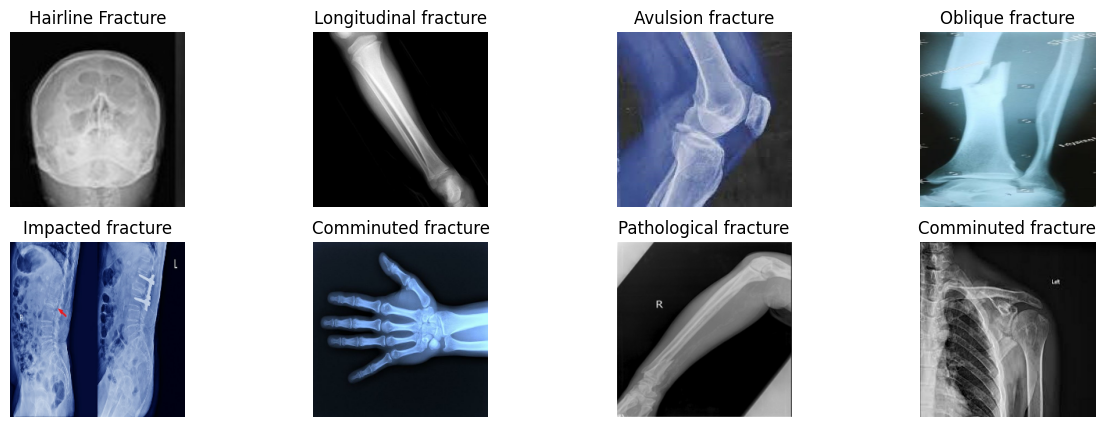

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


class_labels=["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",
              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",
              "Pathological fracture","Spiral Fracture"]
# Initialize the figure and subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 5))

# Iterate through the first 10 images
for i, ax in enumerate(axes.flat):
    # Select the image and label
    image, label = train_x[i], train_y[i]

    # Display the image
    ax.imshow(image, cmap='gray')

    # Set the title with the class label
    ax.set_title(f"{class_labels[np.argmax(label)]}")
    ax.axis('off')

# Display the figure
plt.show()

# Model MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input

# Define the input shape
input_shape = (224, 224, 3)

# Build the MobileNet model with data augmentation and learning rate scheduling
def build_mobilenet(input_shape=(224, 224, 3), num_classes=10):
    # Define the input layer
    inputs = Input(shape=input_shape)

    # Load MobileNet model with pre-trained weights from ImageNet
    base_model = MobileNet(input_shape=input_shape,
                           include_top=False,  # Exclude the top (fully connected) layers
                           weights='imagenet')(inputs)

    # Freeze the layers of the pre-trained model
    base_model.trainable = False

    # Create the custom model on top of the pre-trained base model
    x = layers.GlobalAveragePooling2D()(base_model)  # Global average pooling layer
    x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation

    # Create the final model
    model = models.Model(inputs, outputs)

    # Compile the model with reduced learning rate
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Add data augmentation and learning rate scheduler
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1  # Reduce learning rate by a factor of 10 after 10 epochs
    return lr

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the model
model = build_mobilenet(input_shape=input_shape, num_classes=10)

# Fit the model with data augmentation and callbacks, set epochs to 10
history = model.fit(datagen.flow(train_x,train_y, batch_size=32),
                    epochs=35,  # Set number of epochs to 10
                    validation_data=(val_x, val_y),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 803ms/step - accuracy: 0.1046 - loss: 2.8079 - val_accuracy: 0.1762 - val_loss: 2.2563 - learning_rate: 1.0000e-04
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.2033 - loss: 2.2295 - val_accuracy: 0.2785 - val_loss: 2.0087 - learning_rate: 1.0000e-04
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 385ms/step - accuracy: 0.2863 - loss: 1.9931 - val_accuracy: 0.3875 - val_loss: 1.7702 - learning_rate: 1.0000e-04
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.3649 - loss: 1.8239 - val_accuracy: 0.4695 - val_loss: 1.5795 - learning_rate: 1.0000e-04
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.4111 - loss: 1.7099 - val_accuracy: 0.5230 - val_loss: 1.4442 - learning_rate: 1.0000e-04
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - accuracy: 0.4435 - loss: 1.6245 - val_accuracy: 0.5230 - val_loss: 1.3774 - learning_rate: 1.0000e-04
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.45

# Evaluasi Model

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8140 - loss: 0.6581
Validation Loss: 0.6371656656265259, Validation Accuracy: 0.8231707215309143


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,822,368 (48.91 MB)

 Trainable params: 4,266,826 (16.28 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 8,533,654 (32.55 MB)

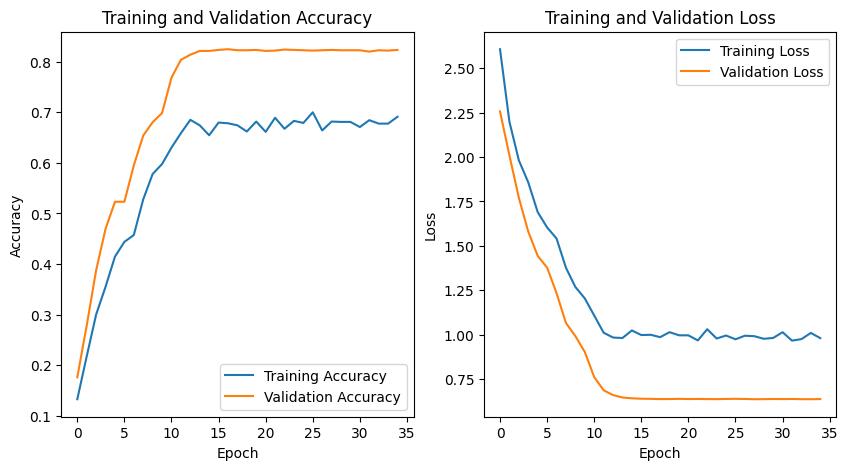

In [ ]:
# Evaluasi model
loss, accuracy = model.evaluate(val_x, val_y)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

model.summary()


# Plot the accuracy and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Plot Hasil Prediksi vs Aktual

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step


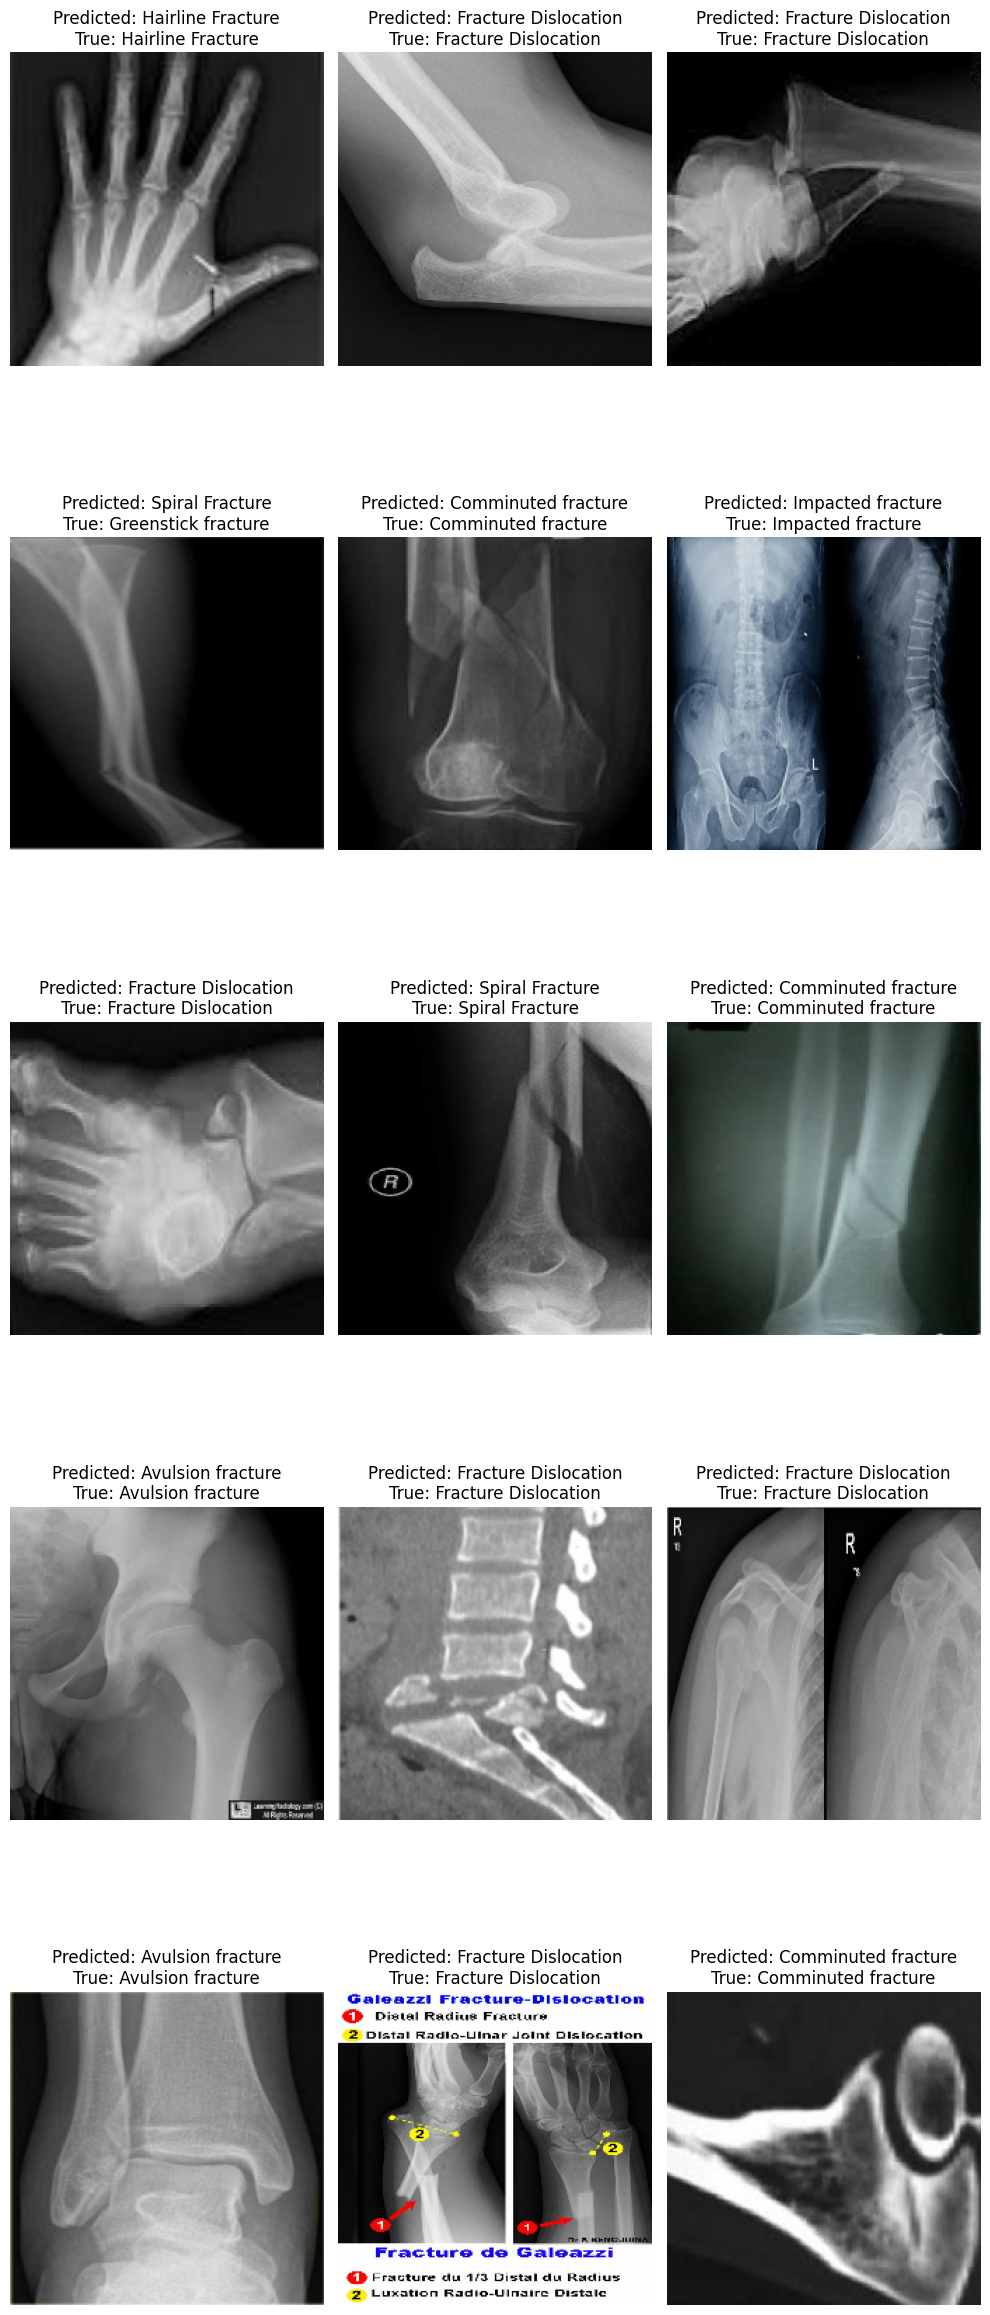

In [ ]:
# Make predictions on the validation set
predictions = model.predict(val_x)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = np.argmax(val_y, axis=1)

# Initialize the figure and subplots
fig, axes = plt.subplots(5, 3, figsize=(10, 25))

# Iterate through the first 10 images
for i, ax in enumerate(axes.flat):
    # Select the image, predicted label, and true label
    image, predicted_label, true_label = val_x[i], predicted_labels[i], true_labels[i]

    # Display the image
    ax.imshow(image)

    # Set the title with the predicted and true labels
    ax.set_title(f"Predicted: {class_labels[predicted_label]}\nTrue: {class_labels[true_label]}")
    ax.axis('off')

# Display the figure
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

# Evaluation report

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report:
                       precision    recall  f1-score   support

    Avulsion fracture       0.81      0.90      0.85       167
  Comminuted fracture       0.75      0.84      0.79       143
 Fracture Dislocation       0.92      0.90      0.91       208
  Greenstick fracture       0.74      0.93      0.82       119
    Hairline Fracture       0.89      0.84      0.87       184
    Impacted fracture       0.72      0.76      0.74       147
Longitudinal fracture       0.81      0.60      0.69       124
     Oblique fracture       0.89      0.73      0.80        88
Pathological fracture       0.87      0.88      0.88       164
      Spiral Fracture       0.83      0.73      0.77       132

             accuracy                           0.82      1476
            macro avg       0.82      0.81      0.81      1476
         weighted avg       0.83      0.82      0.82      1476



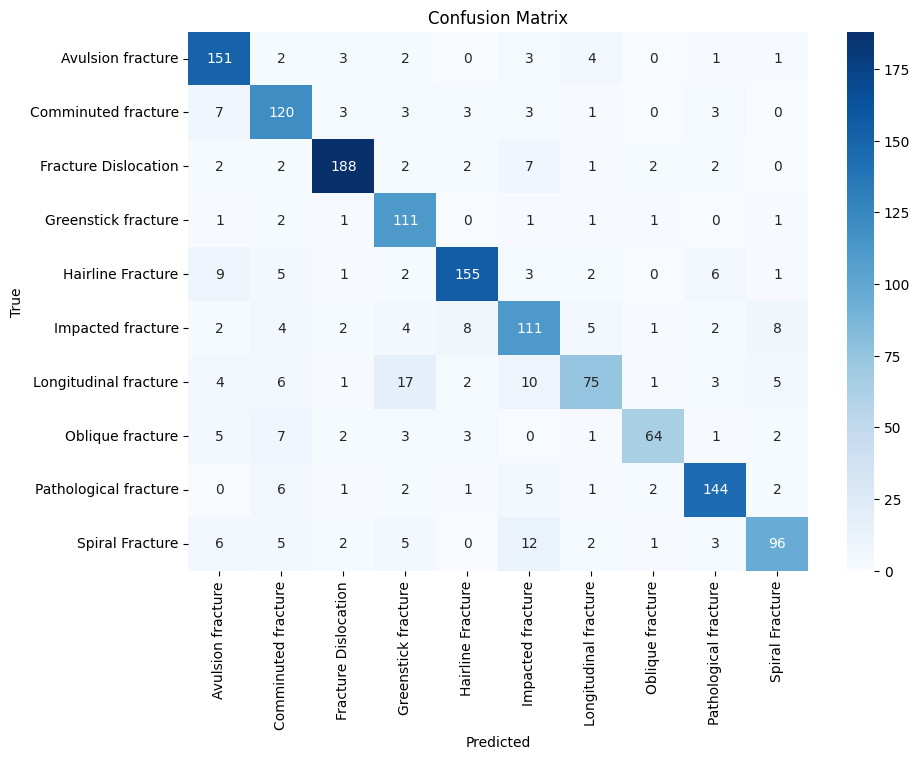

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Example class names (replace with your actual class names)
class_names = ["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",
              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",
              "Pathological fracture","Spiral Fracture"]

# Predict on the validation set
y_pred = model.predict(val_x)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# Convert true labels to class indices
y_true = np.argmax(val_y, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Coba Prediksi dengan data baru
https://www.kaggle.com/datasets/shyamgupta196/bone-fracture-split-classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Avulsion fracture
Prediction Confidence: 0.9651


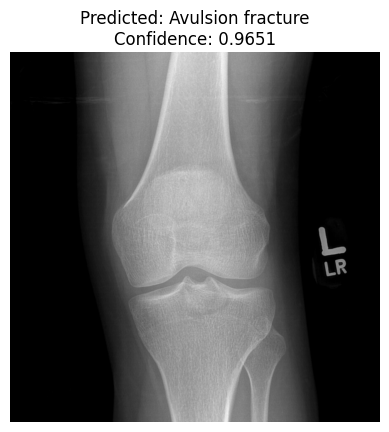

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Fungsi untuk memuat gambar dan melakukan preprocessing
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Muat gambar
    img = image.load_img(img_path, target_size=target_size)

    # Konversi gambar menjadi array numpy
    img_array = image.img_to_array(img)

    # Tambahkan dimensi batch (karena model menerima input dengan batch size)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar agar sesuai dengan yang digunakan saat pelatihan
    img_array /= 255.0

    return img_array

# Tentukan path gambar baru yang ingin diuji
img_path = "/content/drive/MyDrive/Tubes DL/test/Avulsion fracture/9896089d1b31b0ba0158dc33122899_jumbo.jpeg"

# Preprocessing gambar
img_array = load_and_preprocess_image(img_path)

# Prediksi menggunakan model
predictions = model.predict(img_array)

# Mendapatkan kelas yang diprediksi (indeks kelas)
predicted_class = np.argmax(predictions, axis=1)

# Nama kelas
class_names = ["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",
              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",
              "Pathological fracture","Spiral Fracture"]

# Menampilkan hasil prediksi
print(f'Predicted Class: {class_names[predicted_class[0]]}')
print(f'Prediction Confidence: {predictions[0][predicted_class[0]]:.4f}')

# Menampilkan gambar yang diuji
img = image.load_img(img_path)
plt.imshow(img)
plt.axis('off')  # Menyembunyikan axis
plt.title(f'Predicted: {class_names[predicted_class[0]]}\nConfidence: {predictions[0][predicted_class[0]]:.4f}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class: Hairline Fracture
Prediction Confidence: 0.9615


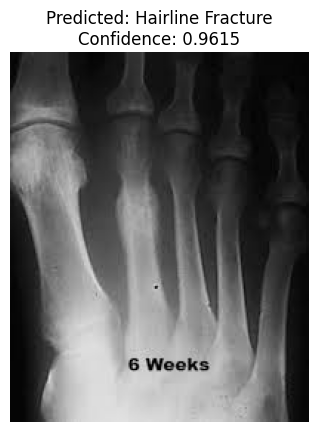

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Fungsi untuk memuat gambar dan melakukan preprocessing
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Muat gambar
    img = image.load_img(img_path, target_size=target_size)

    # Konversi gambar menjadi array numpy
    img_array = image.img_to_array(img)

    # Tambahkan dimensi batch (karena model menerima input dengan batch size)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar agar sesuai dengan yang digunakan saat pelatihan
    img_array /= 255.0

    return img_array

# Tentukan path gambar baru yang ingin diuji
img_path = "/content/drive/MyDrive/Tubes DL/test/Hairline Fracture/image20.jpeg"

# Preprocessing gambar
img_array = load_and_preprocess_image(img_path)

# Prediksi menggunakan model
predictions = model.predict(img_array)

# Mendapatkan kelas yang diprediksi (indeks kelas)
predicted_class = np.argmax(predictions, axis=1)

# Nama kelas
class_names = ["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",
              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",
              "Pathological fracture","Spiral Fracture"]

# Menampilkan hasil prediksi
print(f'Predicted Class: {class_names[predicted_class[0]]}')
print(f'Prediction Confidence: {predictions[0][predicted_class[0]]:.4f}')

# Menampilkan gambar yang diuji
img = image.load_img(img_path)
plt.imshow(img)
plt.axis('off')  # Menyembunyikan axis
plt.title(f'Predicted: {class_names[predicted_class[0]]}\nConfidence: {predictions[0][predicted_class[0]]:.4f}')
plt.show()

Untuk hasil uji pakai data baru dengan 1 per 1 gambar model masih bisa untuk memprediksi dengan tepat

# Prediksi dengan data baru dalam jumlah besar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━

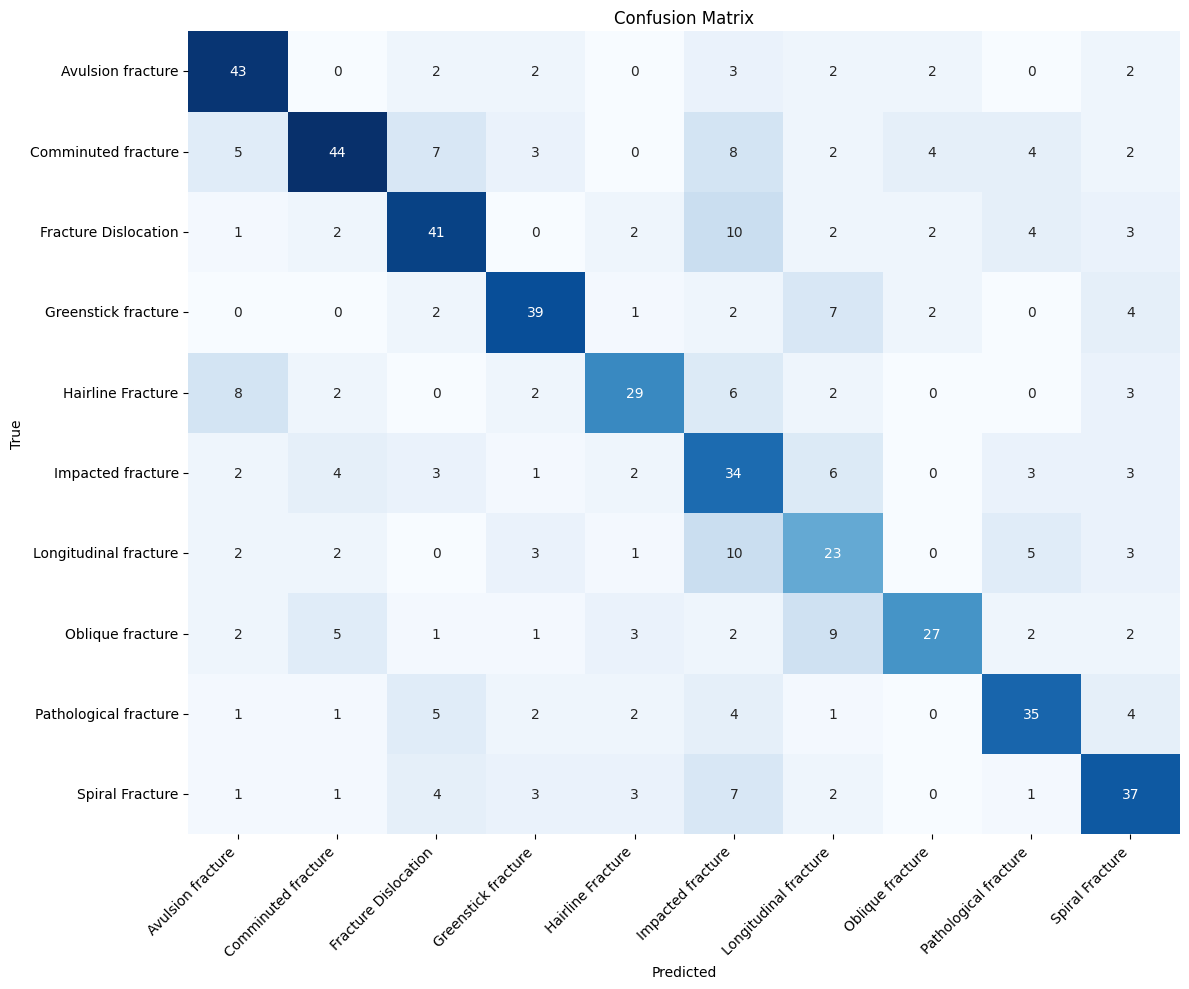

In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Fungsi untuk memuat gambar dan melakukan preprocessing
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Muat gambar
    img = image.load_img(img_path, target_size=target_size)

    # Konversi gambar menjadi array numpy
    img_array = image.img_to_array(img)

    # Tambahkan dimensi batch (karena model menerima input dengan batch size)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar agar sesuai dengan yang digunakan saat pelatihan
    img_array /= 255.0

    return img_array

# Fungsi untuk memproses semua gambar dalam folder dan menghitung evaluasi
def evaluate_model_on_folder(folder_path, class_names, target_size=(224, 224)):
    # Variabel untuk menyimpan ground truth dan prediksi
    y_true = []
    y_pred = []

    # Loop melalui setiap kelas (subfolder) dalam folder
    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)

        # Pastikan subfolder ada
        if os.path.isdir(class_folder):
            img_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

            # Loop untuk memproses setiap gambar dalam folder kelas tersebut
            for img_file in img_files:
                img_path = os.path.join(class_folder, img_file)

                # Preprocessing gambar
                img_array = load_and_preprocess_image(img_path, target_size)

                # Prediksi menggunakan model
                predictions = model.predict(img_array)

                # Mendapatkan kelas yang diprediksi (indeks kelas)
                predicted_class = np.argmax(predictions, axis=1)

                # Menyimpan prediksi dan true label
                y_true.append(class_idx)  # Label yang benar (ground truth)
                y_pred.append(predicted_class[0])  # Prediksi model

    # Menghitung akurasi
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Mencetak laporan klasifikasi yang lebih lengkap
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

    # Menghitung dan menampilkan confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    # Menampilkan confusion matrix dengan heatmap
    plt.figure(figsize=(12, 10))  # Membuat plot lebih besar agar semua label terlihat jelas
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={"size": 10})  # Menambah ukuran angka annotasi
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')  # Memutar label kelas pada sumbu x agar lebih jelas
    plt.yticks(rotation=0)  # Memastikan label kelas pada sumbu y tidak terputar
    plt.tight_layout()  # Agar layout tidak tumpang tindih
    plt.show()

# Tentukan path folder yang berisi subfolder kelas
folder_path = "/content/drive/MyDrive/Tubes DL/test"

# Daftar nama kelas yang sesuai dengan urutan indeks output
class_names = ["Avulsion fracture", "Comminuted fracture", "Fracture Dislocation", "Greenstick fracture",
               "Hairline Fracture", "Impacted fracture", "Longitudinal fracture", "Oblique fracture",
               "Pathological fracture", "Spiral Fracture"]

# Panggil fungsi untuk mengevaluasi model pada folder test
evaluate_model_on_folder(folder_path, class_names)
